# eScience Incubator Project: Data Analytics for Demixing and Decoding Patterns of Population Neural Activity Underlying Addiction Behavior 

### Charles Zhou, Research Scientist at the Center in Neurobiology of Addiction, Pain, and Emotion

The aim of this project is to apply novel statistical and machine learning analysis techniques to large-scale 2-photon calcium imaging data with respect to addiction-related behaviors and assays.



![alt text](fig1.jpg "Title")

In [172]:
# load dependencies
import h5py
import tensortools as tt # toolbox for TCA
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle # for loading behav data

import xarray # for organizing and storing the data 
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
# indicate a file to analyze
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = 'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained\\'
sima_h5_path = root_dir + filename + '_sima_mc.h5'

In [3]:
# trial windowing 

fs = 5
trial_window = np.array([-1, 3]) # in seconds relative to ttl-onset/trial-onset

### Understanding and preprocessing the data

The data are in h5 (HDF5) format, which has the advantage of being able to load portions of the data into memory at a time. Below, we load the data, reorganize the dimensions, and convert it into x-array format. X-array is a python-unique data structure that allows for storage of meta-data.

In [4]:
# imaging data load
data_h5file = h5py.File(sima_h5_path, 'r')
data_h5file.keys()

<KeysViewHDF5 ['imaging']>

In [5]:
data_h5file['imaging'].shape

(15169, 1, 499, 490, 1)

In [135]:
# load a snippit of data and get rid of un-needed singleton dimensions
data_snip = np.squeeze(np.array(data_h5file['imaging'], dtype = int))
data_snip.shape

(15169, 499, 490)

In [136]:
""" typically it's good to have time as the last dimension because one doesn't usually iterate through time, so we'll
 reorganize the data dimension order"""

print(data_snip.transpose(1,2,0).shape)

data_snip = data_snip.transpose(1,2,0)

(499, 490, 15169)


In [137]:
# calculate some meta data

data_dims = data_snip.shape
tvec = np.linspace(0, data_dims[2]/fs, data_dims[2])

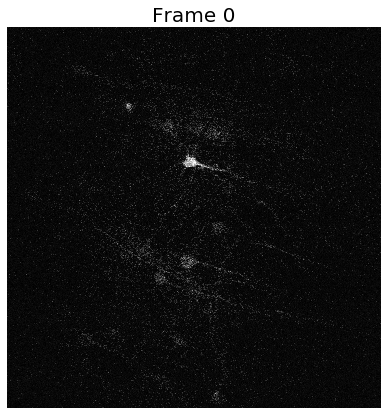

In [138]:
# let's plot the first frame from the video snippit
frame_num = 0
to_plot = data_snip[:,:,frame_num]

plt.figure(figsize = (7,7))
plt.imshow(to_plot, cmap = 'gray')
plt.title(f'Frame {frame_num}', fontsize = 20)
plt.axis('off');

### Let's take a look at the behavioral data.

During the brain recordings, animals perform a behavioral task (pavlovian conditioning) that allows for understanding how neural activity gives rise to memory encoding of rewards. The significance of examining this behavior is that addiction states are heavily based on associating a drug (unconditioned stimulus - US) to a particular cue (eg. heroin needle; conditioned stimulus - CS).

The figure below (Namboodiri et al., 2019 Nature Neuroscience) shows the recording setup and task:

![alt text](namboodiri_nn_fig1ab.png "Title")


We ultimately want to reshape the data for a certain session (typically y_pixels, x_pixels, time/samples) to be amenable to trial-by-trial classifcation in a neural network. The resulting reshaped dimensions will be: trial, y_pixels, x_pixels, time/samples. So for a session with two behavioral conditions 50 trials each, 512x512, and 3 second trials (at 5 hz, that's 15 samples), our resulting array/tensor will be: 100 x 512 x 512 x 15. 

Since we have orders of magnitude more values for x and y pixels than samples, we will ultimately be performing dimensionality reduction to make the dataset more tractable. We will perform dimensionality reduction across y_pixels, x_pixels, and time/samples.

In [144]:
#load behavioral data and trial info
glob_frame_files = glob.glob(root_dir + "framenumberforevents*") # look for a file in specified directory
frame_events = pickle.load( open( glob_frame_files[0], "rb" ), encoding="latin1" ) # latin1 b/c original pickle made in python 2

### Raw behavioral data organization

Across the whole recording session, the animal is presented with randomized stimuli paired with or without sucrose rewards (each presentation is considered a trial). 

The time (ie. sample) at which each trial occurs relative to the beginning of the session is recorded.



In [62]:
def dict_key_len(dict_, key):
    return len(dict_[key])

In [146]:
# take start and end samples, make a vector of all values between, and repeat that vector num_rep times
def make_tile(start_end, num_rep):
    
    samp_vec = np.arange(start_end[0], start_end[1]+1) # grab all samples between start/end

    tile_array = np.tile(samp_vec,(num_rep,1))
    
    return tile_array

In [205]:
# calculate indices of each trial into an array for efficient trial extraction 

trial_window_samp = trial_window*fs # turn trial start/end times to samples

conditions = ['plus_rewarded','minus']
num_trials_cond = {}

for idx, condition in enumerate(conditions):
   
    # convert window time bounds to samples and make a trial sample vector
    # make an array where the sample indices are repeated in the y axis for n number of trials
    num_trials_cond[condition] = dict_key_len(frame_events,condition)
    
    svec_tile = make_tile(trial_window_samp, num_trials_cond[condition])
    num_trial_samps = svec_tile.shape[1]
    
    # now make a repeated matrix of each trial's ttl on sample in the x dimension
    ttl_repmat = np.repeat(frame_events[condition][:,np.newaxis],num_trial_samps, axis = 1).astype('int')
    
    trial_sample_mat = ttl_repmat + svec_tile
    
    # extract frames in trials and reshape the data
    reshape_dim = xarr_data.shape[:-1] + (svec_tile.shape)
    data_trial = data_snip[:,:,np.ndarray.flatten(trial_sample_mat)].reshape( reshape_dim )

## Turn trial-extracted data to xarray

In [195]:
data_flatten_xy = np.reshape(data_snip, 
                             (data_dims[0]*data_dims[1], data_dims[2])) # this flattens only the x,y dimensions

In [210]:
"""let's load data into xarray format, which has numerous 
advantages over using numpy arrays, one of which is the ability 
to assign names to dimensions rather than indexing by ints """

condition = conditions[0]



ypix_vec = range(0,data_dims[0])
xpix_vec = range(0,data_dims[1])
flattenpix_vec = range(0,data_dims[0]*data_dims[1])
trials_vec = range(num_trials_cond[condition])
trial_tvec = np.linspace(trial_window[0], trial_window[1], num_trial_samps)

xarr_data = xarray.DataArray(data_trial, coords=[ypix_vec, xpix_vec, trials_vec, trial_tvec], dims=['y', 'x', 'trial', 'time'])



In [216]:
flatten_pix_trial_data = np.reshape(data_trial, (data_dims[0]*data_dims[1], len(trials_vec), len(trial_tvec)))

xarr_flatten_xy = xarray.DataArray( flatten_pix_trial_data, # this flattens only the x,y dimensions
                                   coords=[flattenpix_vec, trials_vec, trial_tvec], 
                                   dims=['yx', 'trial', 'time'])

In [218]:
# average across trials
xr_avg_trial = xarr_data.mean(dim = 'trial')
xr_flatten_pix_trial = xarr_flatten_xy.mean(dim = 'trial')
xr_flatten_pix_trial

<xarray.DataArray (yx: 244510, time: 21)>
array([[26.4 , 25.58, 31.54, ..., 25.56, 27.8 , 28.98],
       [28.28, 27.06, 27.3 , ..., 27.02, 27.6 , 27.18],
       [27.62, 29.34, 25.4 , ..., 28.7 , 30.  , 27.28],
       ...,
       [31.2 , 26.98, 26.74, ..., 29.02, 28.82, 24.88],
       [25.16, 26.8 , 28.64, ..., 26.04, 25.48, 31.08],
       [30.52, 28.62, 27.72, ..., 28.24, 30.38, 23.84]])
Coordinates:
  * yx       (yx) int32 0 1 2 3 4 5 ... 244505 244506 244507 244508 244509
  * time     (time) float64 -1.0 -0.8 -0.6 -0.4 -0.2 0.0 ... 2.2 2.4 2.6 2.8 3.0

# Scratch stuff

In [219]:
from sklearn_xarray import wrap

c:\users\stuberadmin\anaconda3\envs\escience_incubator\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
pca_obj = PCA(n_components=3)
pca_obj.fit(xarr_data.values[:,:,0])

data_pca = pca_obj.transform(xarr_data[:,:,0])
data_pca

CP_ALS: iteration 1, objective 0.8332517400318319, improvement inf.
CP_ALS: iteration 2, objective 0.44685831997224734, improvement 0.38639342005958455.
CP_ALS: iteration 3, objective 0.42155677577908013, improvement 0.025301544193167214.
CP_ALS: iteration 4, objective 0.41734006084153846, improvement 0.004216714937541666.
CP_ALS: iteration 5, objective 0.41703469862504283, improvement 0.00030536221649563045.
CP_ALS: iteration 6, objective 0.4170129075364675, improvement 2.1791088575306983e-05.
CP_ALS: iteration 7, objective 0.4170099062169335, improvement 3.0013195340128362e-06.
Converged after 7 iterations, 0.0061143 seconds. Objective: 0.4170099062169335.
CP_ALS: iteration 1, objective 0.8401788084827222, improvement inf.
CP_ALS: iteration 2, objective 0.5212416892508257, improvement 0.3189371192318965.
CP_ALS: iteration 3, objective 0.46492318910438885, improvement 0.056318500146436856.
CP_ALS: iteration 4, objective 0.42801140400126847, improvement 0.036911785103120376.
CP_ALS: it

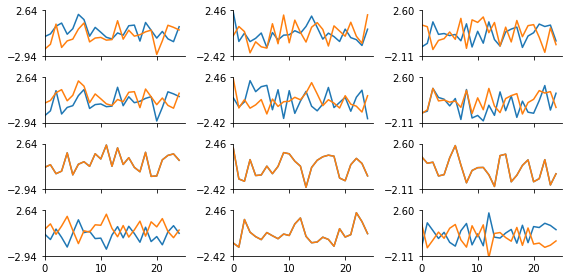

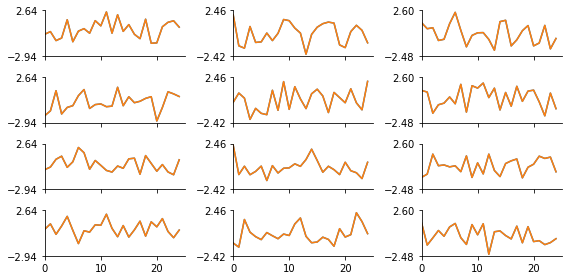

In [9]:
# Make synthetic dataset.
I, J, K, R = 25, 25, 25, 4  # dimensions and rank
X = tt.randn_ktensor((I, J, K), rank=R).full()
X += np.random.randn(I, J, K)  # add noise

# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Show plots.
plt.show()